# New order parameter

In simulations we see that for a given density, clusters with polar order exist but global polar order does not. We would like to characterize a transition between a system with some elongated cells with local polar order (coexisting with round ones), and systems with all cells round. Because of this, we define a new Effective Local Polar Order parameter:

$$ A = f_e \times  P_{local} $$


where $f_e=\frac{N_e}{N}$ and $P_{local}=\frac{1}{N_e} \sum_{i=1}^{N_e} \vert \mathbf{p_i} \vert$. Here $f_e$ is the fraction of elongated cells, and $P_{local}$ is the average of the absolute values of the local polar order parameters. For every elongated cell (this is important, we calculate it only around elongated cells), we can calculate a local polar parameter using the cells in the neighboring buckets in the grid. Then, we can calculate the local order parameter as:

$$\mathbf{p_i}=\frac{1}{N_i} \sum_{j} (\cos (\theta_j), \sin (\theta_j))$$


where $N_i$ is the number of elongated neighboring cells. If a cell has no elongated neighbors ($N_i=0$), we set $\mathbf{p_i}=0$. Because we have $N_e$ elongated cells, we obtain $N_e$ local polar order parameters for each step and seed, and that is why we divide by $N_e$. One thing to be aware of is that if we take into account the cell itself, in the case we only have one cell without neighbors, the local order parameter is 1 and that is not realistic. Because of this, we decided to not take into account the reference cell.

This new order parameter is useful because in the best case, every cell is elongated and there is perfect local polar order, so $A=1$. In general, $A$ can decrease either if the fraction of elongated cells is reduced ($f_e \to 0$) or if elongated cells are locally disordered ($P_{local}\to 0$).

Note that this OP is associated with the ones we already defined for the global order parameters. If we remember:


- Global Nematic Order ($Q$): The well-known nematic order calculated using the number of elongated cells as follows:

$$ Q = \frac{1}{N_e} \sqrt{\left(\sum_{i=1}^{N_e} \sin (2\varphi_i)\right)^2+\left(\sum_{i=1}^{N_e} \cos (2\varphi_i)\right)^2}$$

- Global Polar Order ($P$): The well-known polar order calculated using the number of elongated cells as follows:

$$ P = \frac{1}{N_e} \sqrt{\left(\sum_{i=1}^{N_e} \sin (\varphi_i)\right)^2+\left(\sum_{i=1}^{N_e} \cos (\varphi_i)\right)^2}$$

- Global Nematic Order 2 ($\hat{Q}$): The same nematic parameter as before but dividing by all the cells (including the rounds):

$$ \hat{Q} = \frac{1}{N} \sqrt{\left(\sum_{i=1}^{N_e} \sin (2\varphi_i)\right)^2+\left(\sum_{i=1}^{N_e} \cos (2\varphi_i)\right)^2}$$

- Global Polar Order 2 ($\hat{P}$): The same polar parameter as before but dividing by all the cells (including the rounds):

$$ \hat{P} = \frac{1}{N} \sqrt{\left(\sum_{i=1}^{N_e} \sin (\varphi_i)\right)^2+\left(\sum_{i=1}^{N_e} \cos (\varphi_i)\right)^2}$$

In that case:
$$ \hat{Q} = f_e \times Q $$

$$ \hat{P} = f_e \times P $$

Thus, our new parameter $A$ can be regarded as the local analogue of $\hat{P}$, where instead of averaging global polarization vectors, we average the local polar coherences around elongated cells.

In [1]:
# import the libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define parameters useful for the local order parameter
grid_cube_size = 2*np.sqrt(2.7)  # biggest size of the elongated cells
bin_width = 1.0    # bin width for radial correlation
max_r = 50         # max distance for correlation

# And other parameters that were defined in the simulations
cell_area = np.pi
# All the seeds
number_of_realizations=64

seed_1 = 0x87351080E25CB0FAD77A44A3BE03B491
rng_1 = np.random.default_rng(seed_1)

rng_seed = rng_1.integers(
            low=2**20, high=2**50, size=number_of_realizations
        )

In [3]:
def load_data_and_filter_elongated(dens, seed, num_cells):
    """
    Function to load the positions, orientations and aspect ratios
    of all the cells in the steady state given a density, seed and
    number of cells
    """
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"

    # Path to the folder with local order parameter files
    folder = f"data/{num_cells_folder}/{dens_folder}/dat_final/"
    
    # Find the file for this seed and box_length
    files = [f for f in os.listdir(folder) if f"With_Shrinking_rng_seed={seed}" in f]
    if not files:
        print(f"No file found for seed {seed}")
        return None, None, 0
    
    # There is exactly one file for this seed and box_length
    # Just in case, take the max
    dat_file = os.path.join(folder, max(files))
    
    # Read the file
    df = pd.read_csv(dat_file)

    positions = df[["position_x", "position_y"]].values
    orientations = df["orientation"]
    aspect_ratios = df["aspect_ratio"]

    # Filter elongated cells
    # Filter elongated cells
    indices_elong = np.where(~np.isclose(aspect_ratios, 1))[0]
    pos_elong = positions[indices_elong]
    orien_elong = np.array(orientations[indices_elong])
    N_elong = len(indices_elong)


    return pos_elong, orien_elong, N_elong

In [4]:
def build_grid(number_cells, cell_area, dens, grid_cube_size, pos_elong):
    """ 
    Function that builds the grid. It needs to recalculate the cube size
    in order to have an integer number of buckets.
    """
    # Calculate the bounds of the grid
    bounds = np.sqrt(number_cells * cell_area / dens)
    # Calculate the number of buckets
    number_of_buckets = int(np.floor(bounds / grid_cube_size))
    # Update the cube_size in order to have
    # an integer number of buckets completed
    cube_size = bounds/number_of_buckets
    # Create the grid
    grid = {}
    for i, pos in enumerate(pos_elong):
        key = tuple(np.floor(pos / cube_size).astype(int) % number_of_buckets)
        if key not in grid:
            grid[key] = []
        grid[key].append(i)
    return grid, number_of_buckets, cube_size

In [ ]:
def calculate_local_order(N_elong, pos_elong, cube_size, number_of_buckets, grid, orien_elong):
    """
    Calculates the local order parameters given the grid and the information of the cells.
    Returns an array with the local parameter vector for every elongated cell.
    """
    # offsets for neighboring boxes (including self)
    offsets = [(dx, dy) for dx in [-1,0,1] for dy in [-1,0,1]]
    
    # local order vectors
    p_local = np.zeros((N_elong, 2))
    
    for i, pos in enumerate(pos_elong):
        key = tuple(np.floor(pos / cube_size).astype(int) % number_of_buckets)
        neighbors_idx = []
        for dx, dy in offsets:
            neighbor_key = ((key[0]+dx) % number_of_buckets,
                            (key[1]+dy) % number_of_buckets)
            if neighbor_key in grid:
                neighbors_idx.extend(grid[neighbor_key])

        neighbors_idx = [j for j in neighbors_idx if j != i] # Delete if want to include self

        # If no elongated cells, set local order to zero
        if len(neighbors_idx) == 0:
            p_local[i] = [0, 0]
            continue
        
        # Sum the orientations of the neighbors
        cos_sum = np.sum(np.cos(orien_elong[neighbors_idx]))
        sin_sum = np.sum(np.sin(orien_elong[neighbors_idx]))
        p_local[i] = np.array([cos_sum, sin_sum]) / len(neighbors_idx)

    return p_local

In [6]:
def calculate_A(dens, seed, num_cells):
    """
    Calculates the new order parameter A = f_e * P_local
    for a given density, seed, and number of cells.
    """
    # Load data and filter elongated cells
    pos_elong, orien_elong, N_elong = load_data_and_filter_elongated(dens, seed, num_cells)
    if N_elong == 0:
        return 0.0  # no elongated cells -> A=0

    # Build grid
    grid, number_of_buckets, cube_size = build_grid(num_cells, cell_area, dens, grid_cube_size, pos_elong)
    
    # Calculate local order parameters
    p_local = calculate_local_order(N_elong, pos_elong, cube_size, number_of_buckets, grid, orien_elong)

    # Average of magnitudes
    P_local = np.mean(np.linalg.norm(p_local, axis=1))
    # Fraction of elongated cells
    f_e = N_elong / num_cells
    # New order parameter
    A = f_e * P_local
    return A, f_e, P_local


In [7]:
number_of_cells = 10_000

# List of densities to analyze
density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]

# DataFrame to store results
df = pd.DataFrame(columns=["density", "mean_A", "std_A", "mean_f_e", "std_f_e", "mean_P_local", "std_P_local"])

# Loop over densities and seeds
for dens in density_list:
    A_list = []
    f_e_list = []
    P_local_list = []
    for seed in rng_seed:
        A_value, f_e, P_local = calculate_A(dens, seed, number_of_cells)
        A_list.append(A_value)
        f_e_list.append(f_e)
        P_local_list.append(P_local)
    mean_A = np.mean(A_list)
    std_A = np.std(A_list)
    mean_f_e = np.mean(f_e_list)
    std_f_e = np.std(f_e_list)
    mean_P_local = np.mean(P_local_list)
    std_P_local = np.std(P_local_list)
    df.loc[len(df)] = [dens, mean_A, std_A, mean_f_e, std_f_e, mean_P_local, std_P_local]

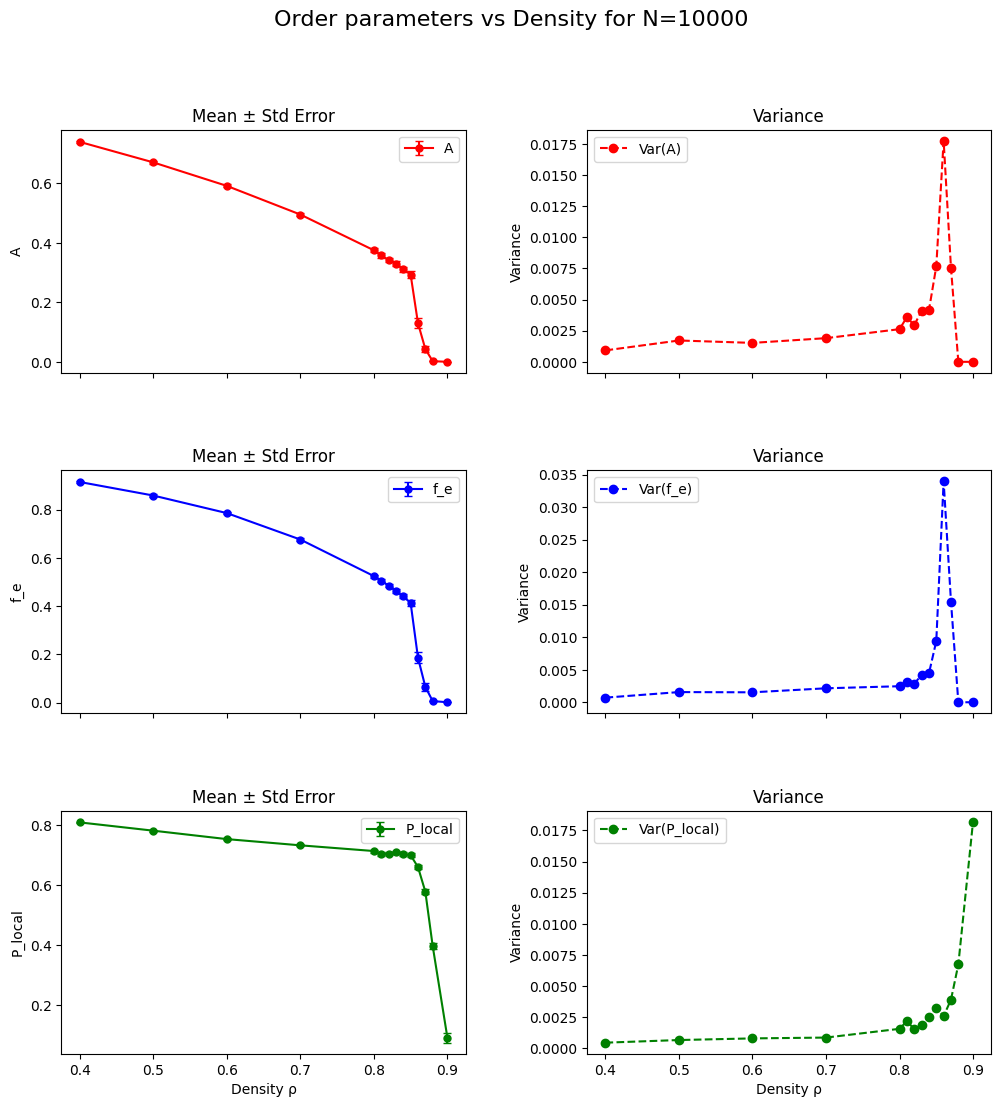

In [8]:
# Create folder if it doesn't exist
num_cells_folder = f"N={number_of_cells:_}"
graph_folder = f"graphs/{num_cells_folder}/A"
os.makedirs(graph_folder, exist_ok=True)

# Error bars
error_A = df["std_A"] / np.sqrt(len(rng_seed))
error_f_e = df["std_f_e"] / np.sqrt(len(rng_seed))
error_P_local = df["std_P_local"] / np.sqrt(len(rng_seed))

# Subplots 3x2
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- Row 1: A ---
axes[0,0].errorbar(df["density"], df["mean_A"], yerr=error_A, fmt='o-', color="red", capsize=3, markersize=5, label="A")
axes[0,0].set_ylabel("A")
axes[0,0].set_title("Mean ± Std Error")
axes[0,0].legend()

axes[0,1].plot(df["density"], df["std_A"]**2, 'o--', color="red", label="Var(A)")
axes[0,1].set_ylabel("Variance")
axes[0,1].set_title("Variance")
axes[0,1].legend()

# --- Row 2: f_e ---
axes[1,0].errorbar(df["density"], df["mean_f_e"], yerr=error_f_e, fmt='o-', color="blue", capsize=3, markersize=5, label="f_e")
axes[1,0].set_ylabel("f_e")
axes[1,0].set_title("Mean ± Std Error")
axes[1,0].legend()

axes[1,1].plot(df["density"], df["std_f_e"]**2, 'o--', color="blue", label="Var(f_e)")
axes[1,1].set_ylabel("Variance")
axes[1,1].set_title("Variance")
axes[1,1].legend()

# --- Row 3: P_local ---
axes[2,0].errorbar(df["density"], df["mean_P_local"], yerr=error_P_local, fmt='o-', color="green", capsize=3, markersize=5, label="P_local")
axes[2,0].set_xlabel("Density ρ")
axes[2,0].set_ylabel("P_local")
axes[2,0].set_title("Mean ± Std Error")
axes[2,0].legend()

axes[2,1].plot(df["density"], df["std_P_local"]**2, 'o--', color="green", label="Var(P_local)")
axes[2,1].set_xlabel("Density ρ")
axes[2,1].set_ylabel("Variance")
axes[2,1].set_title("Variance")
axes[2,1].legend()

fig.suptitle(f"Order parameters vs Density for N={number_of_cells}", fontsize=16)
plt.savefig(f"{graph_folder}/A_f_e_P_local_N={number_of_cells}.png", dpi=600)
plt.show()
plt.close()

